<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [1]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20151586" #@param {type:"string"}
Student_full_name = "Carlos Siqueira do Amaral" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [4]:
# Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import pickle

import pymc3 as pm
import theano as tt
import arviz as az

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy.special import softmax
# from scipy.io import loadmat
# import scipy.optimize as optimize

# from IPython.display import HTML
# import cv2
# from skimage.io import imread, imshow
# from skimage.color import rgb2gray

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
%matplotlib inline

In [5]:
# Setting a seed:
np.random.seed(123)

## Dataset

### Loading the MNIST dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Path, copy the path from your Drive
Path = "/content/drive/MyDrive/UL Masters/ET5003/Week-1/"

# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print(X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print(X_test.shape)

(60000, 784)
(10000, 784)


In [8]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv, maxv)

0.0 1.0


### Description of Data:

In [9]:
# Number of examples
n_train = len(X_train)
n_test = len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


### Class Distribution:

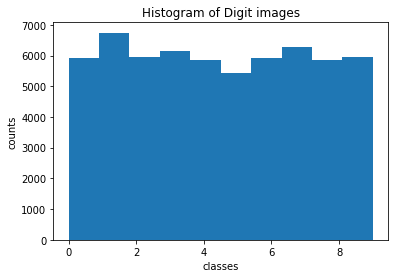

In [10]:
fig, ax = plt.subplots()
ind = np.arange(n_classes)

ax.hist(y_train, bins=n_classes)
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [11]:
# We select the number of Classes we want:
n_classes = 3

classes = np.random.choice(range(10), size=n_classes, replace=False)
classes.sort()
print("Classes selected:", classes)

Classes selected: [0 4 7]


In [12]:
# The number of instances we'll keep for each of our 3 digits:
n_instances = 500

inputs, labels = [], []

# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    inputs.append(
        imgs
        [np.random.permutation(imgs.shape[0]), :] # shuffle the data
        [:n_instances, :] # Reduce dataset size to n_instances
    )
    labels.append(np.ones(n_instances)*r)
    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)

New Classes Distribution

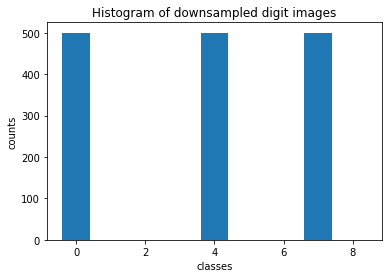

In [13]:
# new histogram
plt.hist(y_train, bins=range(10), align="left", rwidth=0.8)
plt.xlabel('classes')
plt.ylabel('counts')
plt.title('Histogram of downsampled digit images')
plt.show()

As expected, we have 500 instances form each class.

In [14]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))

    row_images = []
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

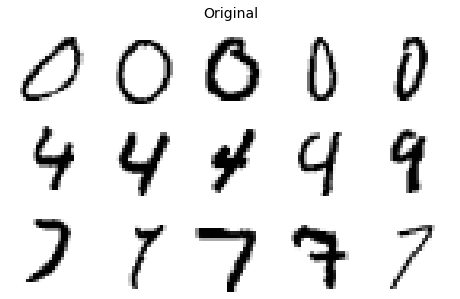

In [15]:
# Show a few instances from each Digit:
plt.figure(figsize=(8,8))

# Selecting a few label indices from each of the 3 classes to show:
label_indices = np.hstack([
    np.random.choice(
        np.where(y_train==label)[0], size=5
    )
    for label in classes
])

# Plotting 'original' image
plot_digits(X_train[label_indices, :], images_per_row=5)
plt.title("Original", fontsize=14)
plt.show()

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [16]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
test_size = 0.20
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=0
)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [17]:
# print shape of your validation and training set
print("Training set shape", X_train.shape)
print("Validation set shape", X_val.shape)

Training set shape (1200, 784)
Validation set shape (300, 784)


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

### General-Recipe ML

In [18]:
def print_metrics(y_true, y_hat):
    print(f"\tPrecision: {precision_score(y_hat, y_true, average='macro'):.2%}")
    print(f"\tRecall: {recall_score(y_hat, y_true, average='macro'):.2%}")
    print(f"\tAccuracy: {accuracy_score(y_hat, y_true):.2%}")

In [19]:
# model
log_clf = LogisticRegression(
    random_state=123,
    max_iter=1000,
    multi_class="multinomial"
)
log_clf.fit(X_train, y_train)

# Classification:
y_pred_log = log_clf.predict(X_val)
y_pred_logi_prob = log_clf.predict_proba(X_val)

In [20]:
print("General Logistic Regression scores:")
print_metrics(y_val, y_pred_log)

General Logistic Regression scores:
	Precision: 98.31%
	Recall: 98.29%
	Accuracy: 98.33%


Below we plot the sorted probabilities of the model predictions for the validation set.

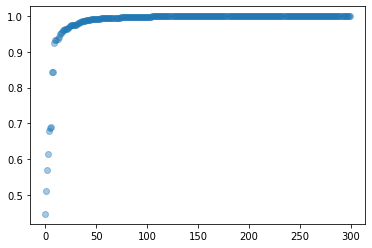

In [21]:
plt.scatter(
    range(len(X_val)),
    sorted(np.max(y_pred_logi_prob, axis=1)),
    alpha=0.4
)
plt.show()

From the plot above we see that the general Logistic Regression model only has a few instances where it is not confident of the result (those near the bottom left of the plot)

### Probabilistic Multinomial Logistic Regression:

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [22]:
from sklearn.preprocessing import LabelBinarizer

binarizer = LabelBinarizer()
y_train_bin = binarizer.fit_transform(y_train.reshape(-1, 1))

n_classes = len(classes)
n_features = X_train.shape[-1]
init_a = np.random.randn(n_classes-1).astype(tt.config.floatX)
init_b = np.random.randn(n_features, n_classes-1).astype(tt.config.floatX)

with pm.Model() as model:
    # setting up the priors
    ß = pm.Normal(
        "beta",
        mu=0,
        sigma=100,
        shape=(n_features, n_classes-1),
        testval=init_b,
    )
    α = pm.Normal(
        "alpha",
        mu=0,
        sigma=100,
        shape=(n_classes-1, ),
        testval=init_a
    )

    # ?? 
    β_1 = tt.tensor.concatenate(
        [np.zeros((n_features, 1)), ß],
        axis=1
    )
    α_1 = tt.tensor.concatenate([[0], α])

    # Likelihood, our assumption of what the data looks like.
    # We use logistic regression by applying softmax to a simple
    # Linear relationship between the parameters
    p = tt.tensor.nnet.nnet.softmax(
        pm.math.matrix_dot(X_train, β_1) + α_1
    )
    
    likelihood = pm.Multinomial("likelihood", p=p, observed=y_train_bin, n=1)

    # Fit the model
    approx = pm.fit(3000, method="advi")
approx.model

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 7,506.1


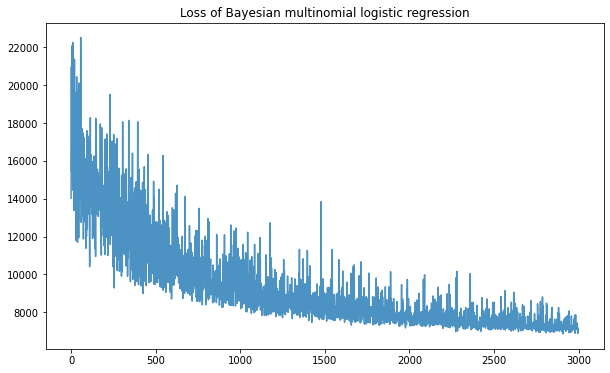

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(approx.hist, alpha=0.8)
ax.set_title("Loss of Bayesian multinomial logistic regression")
plt.show()

Let's use Arviz `plot_trace` functionality to examine the posterior distribution.

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


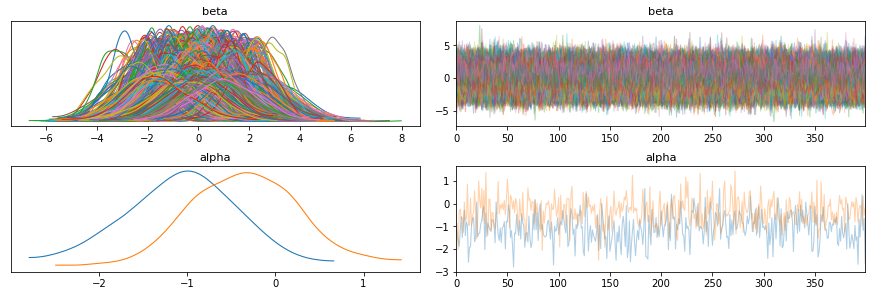

In [24]:
n_samples = 400
posterior = approx.sample(n_samples)

az.plot_trace(posterior)
plt.show()

The kernel density estimate for $\beta$ is unreadable as we have 784 features per class for our data. 

The plot for $\alpha$ however is more interesting and shows that the model was able to identify that each class has a different mean intercept and standard deviation

Now let's examine the predictions

In [25]:
def zero_pad(arr):
    """Pads the last axis of arr with zeros.
    
    Args
    ----
        arr : np.ndarray
            Array to be padded
    
    Returns
    -------
        np.ndarray
    """
    return np.concatenate(
        [
            np.zeros(arr.shape[:-1] + (1, )),
            arr
        ],
        axis=-1
    )

def predict(posterior, X):
    """Generates Bayesian Logistic regression predictions based on a learned
    posterior.

    Parameters
    ----------
    posterior : pymc3.backends.base.MultiTrace
        The learned posterior parameters
    X : np.ndarray
        Dataset features

    Returns
    -------
    y_probas : np.ndarray
        Class probabilities obtained with softmax
    y_preds : np.ndarray
        Predicted classes
    """
    alpha = zero_pad(posterior["alpha"])
    beta = zero_pad(posterior["beta"])

    # Take softmax along the last axis which represents each class
    logits = softmax(X.dot(beta) + alpha, axis=-1) 
    y_probas = (
        np.sum(logits, axis=1) # Sum logits across all samples
        / len(posterior) # Then normalize them
    )
    y_preds = np.argmax(y_probas, axis=1)
    return y_probas, y_preds

In [28]:
y_probas, y_preds = predict(posterior, X_val)
y_preds[:10]

array([0, 0, 2, 0, 2, 2, 1, 0, 0, 2])

In [29]:
print("Probabilistic Bayesian Logistic Regression scores:")
print_metrics(y_val, (np.array(classes)[y_preds]))

Probabilistic Bayesian Logistic Regression scores:
	Precision: 97.28%
	Recall: 97.30%
	Accuracy: 97.33%


# Calculating posterior uncertainty

To identify which instances the model found easy and hard to classify, we will look at the standard deviation of the prediction across all samples for each instance.

This means that for each instance we will have a 2-D array of shape (n_samples, n_classes) where entries will be 1 if the model assigned the highest probability to that class. For example

```
[[1, 0, 0],
 [0, 1, 0],
 [1, 0, 0],
 ...,
 [0, 0, 1],
 [1, 0, 0],
 [0, 1, 0]],
```
We call this the `rank` matrix. Next we calculate the standard deviation across each class (i.e. axis 0 - columns) and sort the instances across this dimension in descending order. This will give us the instanced that had highest deviation in the prediction, i.e. the hardest ones to classify!

Note that there are three levels of dimensionality here: `instance`, `sample` and `class`. By instance we mean each data point in the dataset being evaluated (in this case `X_val`). By sample, we mean each value drawn from the posterior. Finally by class, we mean which label we're predicting. 

In [30]:
def assign_ranks(logits):
    """Helper function to create a rank matrix.
    
    The rank matrix is of shape (len(X), n_samples, n_classes) and its entries
    are marked 1 for the class that has the highest logits for each sample.

    Adapted from: https://stackoverflow.com/questions/42519475/python-numpy-argmax-to-max-in-multidimensional-array

    Parameters
    ----------
    logits : np.ndarray
        A matrix of shape (len(X), n_samples, n_classes)
    
    Returns
    -------
    np.ndarray
        A matrix of shape (len(X), n_samples, n_classes) where each entries
        with 1 indicate the class with highest probability
    """
    pred_idx = np.argmax(logits, axis=-1)
    m, n = logits.shape[:2]
    I, J = np.ogrid[:m, :n]
    
    ranks = np.zeros(shape=logits.shape, dtype=int)
    ranks[I, J, pred_idx] = 1
    return ranks

def prediction_stats(posterior, X):
    """Generates statistics for Bayesian prediction.

    Parameters
    ----------
    posterior : pymc3.backends.base.MultiTrace
        The learned posterior parameters
    X : np.ndarray
        Dataset features

    Returns
    -------
    stats : np.ndarray
        An array of shape (len(X), 3) with prediction statistics
    
    Notes
    -----
    The columns of the returned array are as follows
        0: The predicted class
        1: Predicted class probability
        2: Standard deviation of predicted classes across all samples
    
    To calculate the last metric we create an (n_samples, n_classes) matrix
    where each entry is assigned 1 if that is the class with highest
    probability.
    """
    alpha = zero_pad(posterior["alpha"])
    beta = zero_pad(posterior["beta"])

    logits = softmax(X.dot(beta) + alpha, axis=-1)
    mean_logits = np.mean(logits, axis=1)  # mean logits across all samples
    y_pred = np.argmax(mean_logits, axis=1) # idx of highest mean logit
    y_pred_proba = mean_logits[range(len(X)), y_pred].reshape(-1, 1)

    ranks = assign_ranks(logits)
    rank_std = np.std(ranks, axis=1)[range(len(X)), y_pred].reshape(-1, 1)
    return np.hstack((y_pred.reshape(-1, 1), y_pred_proba, rank_std))

Now the array below has columns `predicted class`, `mean predicted probability`, `standard deviation`. (mean and standard deviation calculated across samples)

In [31]:
stats = prediction_stats(posterior, X_val)
stats[:5]

array([[0.        , 0.96986614, 0.1483029 ],
       [0.        , 0.67858024, 0.46647615],
       [2.        , 0.81075768, 0.3756328 ],
       [0.        , 0.98383987, 0.12155246],
       [2.        , 0.99787198, 0.04993746]])

## Easy and difficult instances
By sorting the standard deviations we identify difficult/easy instances

In [32]:
difficult = np.argsort(-stats[:, 2])
easy = np.argsort(stats[:, 2])

stats[np.hstack((easy[:2], difficult[:2]))]

array([[1.        , 0.99874068, 0.        ],
       [1.        , 0.99992797, 0.        ],
       [2.        , 0.49933329, 0.49999375],
       [2.        , 0.51476434, 0.49989999]])

The plot below shows the mean probabilty prediction across all samples ($\mu$) and the standard deviation of the predictions ($\sigma$). Note that the instances that are hard to classify have high $\sigma$ and low $\mu$.

We also mark a few easy/difficult instances with markers to understand their behaviour

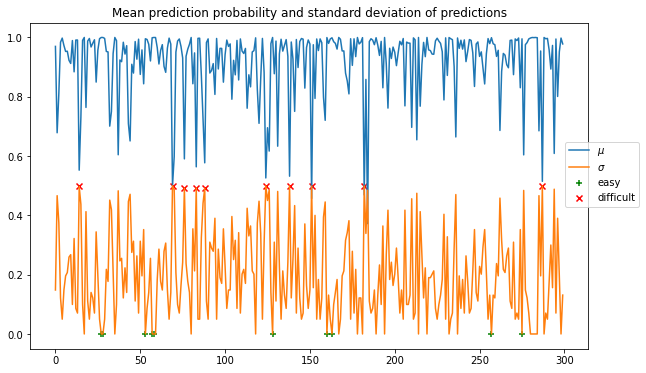

In [33]:
n_instances = 10

plt.figure(figsize=(10, 6))
plt.plot(range(len(X_val)), stats[:, 1], label="$\mu$")
plt.plot(range(len(X_val)), stats[:, 2], label="$\sigma$")
plt.scatter(
    np.arange(len(X_val))[difficult[-n_instances:]],
    stats[difficult[-n_instances:], 2],
    label="easy",
    marker="+",
    c="g"
)
plt.scatter(
    np.arange(len(X_val))[difficult[:n_instances]],
    stats[difficult[:n_instances], 2],
    label="difficult",
    marker="x",
    c="r"
)
plt.title("Mean prediction probability and standard deviation of predictions")
plt.legend(bbox_to_anchor=(.95, .65))
plt.show()

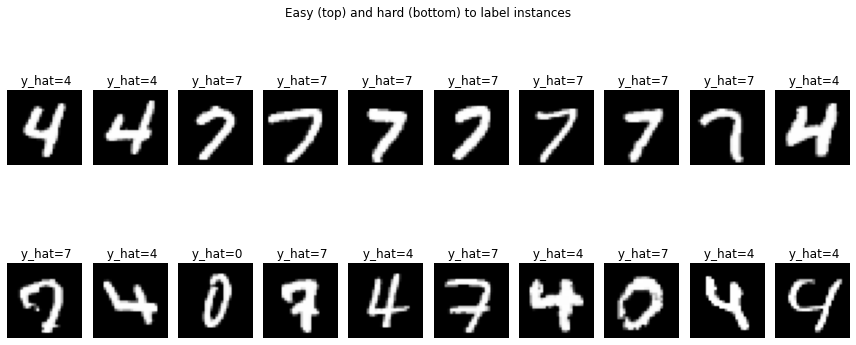

In [34]:
fig, axes = plt.subplots(2, 10, figsize=(12, 6))
# fig.subplots_adjust(hspace = .2, wspace=.001)

for ax, mult in zip(axes, [-1, 1]):
    for idx, axis in enumerate(ax):
        arr = easy if mult==-1 else difficult
        img = X_val[arr[idx]].reshape(28, 28)

        axis.imshow(img, cmap="Greys_r")
        # title_type = "Easy" if mult==-1 else "Difficult"
        title_pred = f" y_hat={y_pred_log[arr[idx]]:.0f}"
        axis.set_title("" + title_pred)
        axis.axis("off")
fig.suptitle("Easy (top) and hard (bottom) to label instances")
fig.tight_layout()
plt.show()


## Classifier accuracy on easy/hard instances
Now that we identified the easy and hard instances, let'see how the general logistic regression classifier performs on these

In [35]:
n_instances = 20

print(f"Classifier metrics on {n_instances} easy instances")
print_metrics(y_val[difficult[-n_instances:]], y_pred_log[difficult[-n_instances:]])

print(f"\nClassifier metrics on {n_instances} difficult instances")
print_metrics(y_val[difficult[:n_instances]], y_pred_log[difficult[:n_instances]])

Classifier metrics on 20 easy instances
	Precision: 100.00%
	Recall: 100.00%
	Accuracy: 100.00%

Classifier metrics on 20 difficult instances
	Precision: 89.17%
	Recall: 92.59%
	Accuracy: 90.00%


In [36]:
def calc_metrics(y_true, y_hat):
    """Helper function to calculate model metrics"""
    return np.array([
        accuracy_score(y_true, y_hat),
        precision_score(y_true, y_hat, average="macro"),
        recall_score(y_true, y_hat, average="macro")
    ])

def log_performance(y_true, y_hat, difficult=difficult):
    scores = np.array([
        calc_metrics(
            y_true[difficult[-idx:]],
            y_hat[difficult[-idx:]]
        )
        for idx in range(1, len(easy))
    ])
    # scores = np.vstack((np.ones((1, 3)), scores))
    return scores

def plot_performance(*args):
    scores = log_performance(*args)[::-1]
    x = range(len(scores))

    plt.figure(figsize=(12, 6))
    plt.plot(x, scores[:, 0], "-", label="accuracy")
    plt.plot(x, scores[:, 1], "--", label="precision")
    plt.plot(x, scores[:, 2], ":", label="recall")
    plt.legend()
    plt.title("Model performance on validation set after removing N difficult instances")
    plt.xlabel("# of hard instances removed")
    plt.show()

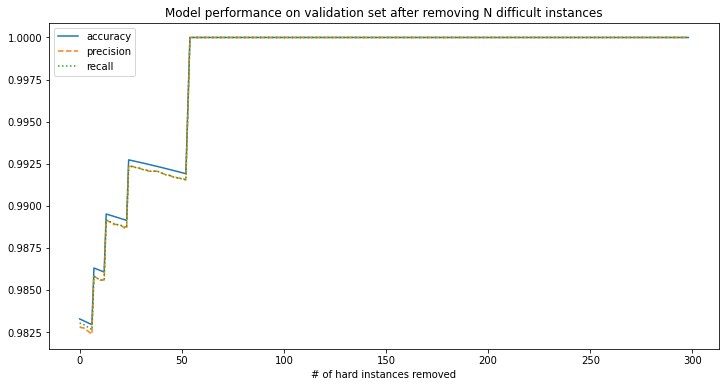

In [37]:
plot_performance(y_val, y_pred_log)

As expected the performance was perfect on the easy instances and it dropped for the difficult instances

## Summary

Populate this section with all of your findings and comments fron the discussion with your peers.